# **Convolutional Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0005
- Layers: [64, 32, 32]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_1s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [4]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/CNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **CNN Model**

In [9]:
def build_model(audio_features,
                learning_rate=0.00005):

  tf.keras.backend.clear_session()

  # set audio features input layer
  inputs = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2],audio_features.shape[3]), name='Audio_Features')


  features = tf.keras.layers.Conv2D(
              filters=64,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              data_format='channels_last',
              name='conv_1',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(inputs)

  features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1')(features)


  features = tf.keras.layers.Conv2D(
              filters=32,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              name='conv_2',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(features)

  # features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_2')(features)


  # features = tf.keras.layers.Conv2D(
  #             filters=32,
  #             kernel_size=(5,5),
  #             strides=(1,1),
  #             padding='same',
  #             name='conv_3',
  #             activation='relu',
  #             kernel_regularizer=tf.keras.regularizers.l2(0.15))(features)

  # features = tf.keras.layers.BatchNormalization()(features)
  features = tf.keras.layers.MaxPool2D(pool_size=(4,4), name='pool_3')(features)

  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=256,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=0.5)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities
  outputs = tf.keras.layers.Dense(
      units=20,
      name='fc_2',
      activation='softmax')(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[inputs],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [10]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_1s_model_training_history_2D_annotated_2.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [12]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [13]:
train_results = {}
val_results = {}

val_scores = {}

### With All Features

In [14]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(train_features['cqt'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled, cqt_tiled), axis=-1)
print(training_features.shape)

(12565, 128, 87, 4)


In [15]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(val_features['cqt'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled, cqt_tiled), axis=-1)
print(validation_features.shape)

(3318, 128, 87, 4)


In [16]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 4)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,373,812 (5.24 MB)

 Trainable params: 1,373,812 (5.24 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.2086 - loss: 10.2003 - weighted_accuracy: 0.2086 - val_accuracy: 0.3620 - val_loss: 6.2863 - val_weighted_accuracy: 0.3620
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4604 - loss: 5.7620 - weighted_accuracy: 0.4604 - val_accuracy: 0.5726 - val_loss: 4.5642 - val_weighted_accuracy: 0.5726
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5924 - loss: 4.3253 - weighted_accuracy: 0.5924 - val_accuracy: 0.6564 - val_loss: 3.7823 - val_weighted_accuracy: 0.6564
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6766 - loss: 3.5562 - weighted_accuracy: 0.6766 - val_accuracy: 0.6727 - val_loss: 3.3405 - val_weighted_accuracy: 0.6727
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7111 - loss: 3.0843 - weighted_accuracy: 0.7111 - val_accuracy: 0.6733 - val_loss: 3.0732 - val_weighted_accuracy: 0.6733
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s

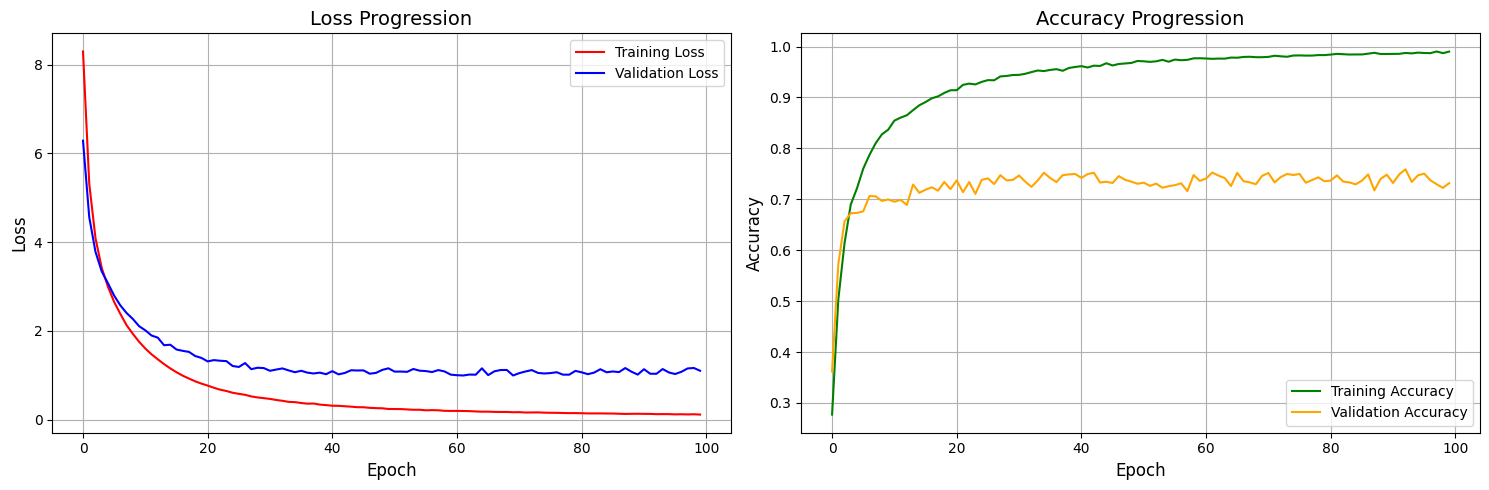

In [17]:
visualize(history, 'all_features')

In [18]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 1.0000 - loss: 0.0742 - weighted_accuracy: 1.0000
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7366 - loss: 1.0833 - weighted_accuracy: 0.7366


In [19]:
val_scores['all_features'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.78      0.68      0.73       455
           1       0.53      0.82      0.64       492
           2       0.86      0.75      0.80       889
           3       0.75      0.85      0.79       150
           4       0.56      0.07      0.13        67
           5       0.77      0.23      0.36        43
           6       0.41      0.67      0.51        24
           7       1.00      1.00      1.00        44
           8       0.60      0.72      0.65        50
           9       0.87      0.98      0.92       169
          10       0.58      0.49      0.53        53
          11       0.43      0.33      0.38        66
          12       0.98      0.83      0.90        59
          13       0.59      0.63      0.61        57
          14       0.43      0.76      0.55        38
          15       0.84      0.58      0.69       311
          16       1.00      0.93      0.96   

### Mel Spectrogram and Chroma

In [20]:
# Train features
target_size = 128
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'],  chroma_tiled), axis=-1)
print(training_features.shape)

(12565, 128, 87, 2)


In [21]:
# Validation Features
target_size = 128
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'],  chroma_tiled), axis=-1)
print(validation_features.shape)

(3318, 128, 87, 2)


In [22]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 2)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,370,612 (5.23 MB)

 Trainable params: 1,370,612 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.1855 - loss: 8.0910 - weighted_accuracy: 0.1855 - val_accuracy: 0.3195 - val_loss: 4.6017 - val_weighted_accuracy: 0.3195
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3793 - loss: 4.0730 - weighted_accuracy: 0.3793 - val_accuracy: 0.4855 - val_loss: 2.7961 - val_weighted_accuracy: 0.4855
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4842 - loss: 2.6415 - weighted_accuracy: 0.4842 - val_accuracy: 0.5422 - val_loss: 2.1042 - val_weighted_accuracy: 0.5422
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5430 - loss: 2.0352 - weighted_accuracy: 0.5430 - val_accuracy: 0.5609 - val_loss: 1.8060 - val_weighted_accuracy: 0.5609
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5868 - loss: 1.7344 - weighted_accuracy: 0.5868 - val_accuracy: 0.5877 - val_loss: 1.6183 - val_weighted_accuracy: 0.5877
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 

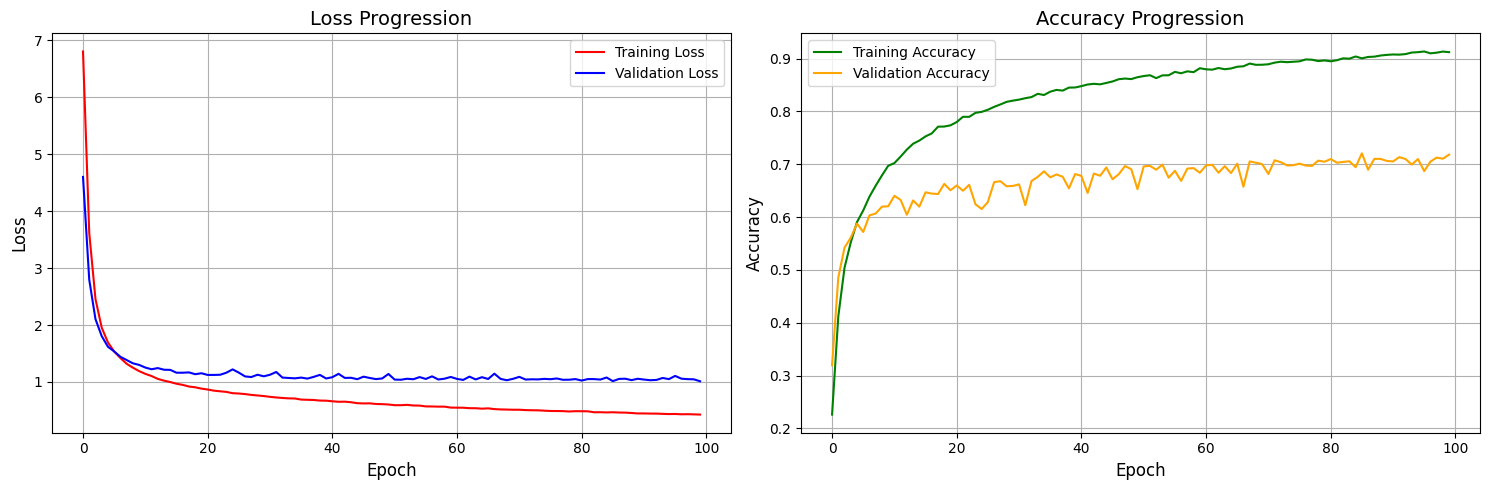

In [23]:
visualize(history, 'melspectrogram_chroma')

In [24]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9557 - loss: 0.3151 - weighted_accuracy: 0.9557
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7186 - loss: 1.0223 - weighted_accuracy: 0.7186


In [25]:
val_scores['melspectrogram_chroma'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       455
           1       0.51      0.57      0.54       492
           2       0.73      0.67      0.70       889
           3       0.80      0.99      0.88       150
           4       0.55      0.16      0.25        67
           5       0.55      0.40      0.46        43
           6       0.35      0.33      0.34        24
           7       0.91      0.98      0.95        44
           8       0.61      0.50      0.55        50
           9       0.94      0.99      0.97       169
          10       0.90      0.72      0.80        53
          11       0.65      0.47      0.54        66
          12       0.79      0.71      0.75        59
          13       0.56      0.70      0.62        57
          14       0.61      0.89      0.72        38
          15       0.68      0.74      0.71       311
          16       0.95      0.95      0.95   

### With Mel Spectrogram, MFCCs and Chroma

In [26]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(training_features.shape)

(12565, 128, 87, 3)


In [27]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(validation_features.shape)

(3318, 128, 87, 3)


In [28]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,372,212 (5.23 MB)

 Trainable params: 1,372,212 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.2033 - loss: 8.3283 - weighted_accuracy: 0.2033 - val_accuracy: 0.2975 - val_loss: 4.8728 - val_weighted_accuracy: 0.2975
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3759 - loss: 4.3429 - weighted_accuracy: 0.3759 - val_accuracy: 0.5178 - val_loss: 2.9965 - val_weighted_accuracy: 0.5178
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4963 - loss: 2.8487 - weighted_accuracy: 0.4963 - val_accuracy: 0.5383 - val_loss: 2.2940 - val_weighted_accuracy: 0.5383
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5580 - loss: 2.1925 - weighted_accuracy: 0.5580 - val_accuracy: 0.5750 - val_loss: 1.9133 - val_weighted_accuracy: 0.5750
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5957 - loss: 1.8589 - weighted_accuracy: 0.5957 - val_accuracy: 0.5946 - val_loss: 1.7208 - val_weighted_accuracy: 0.5946
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 

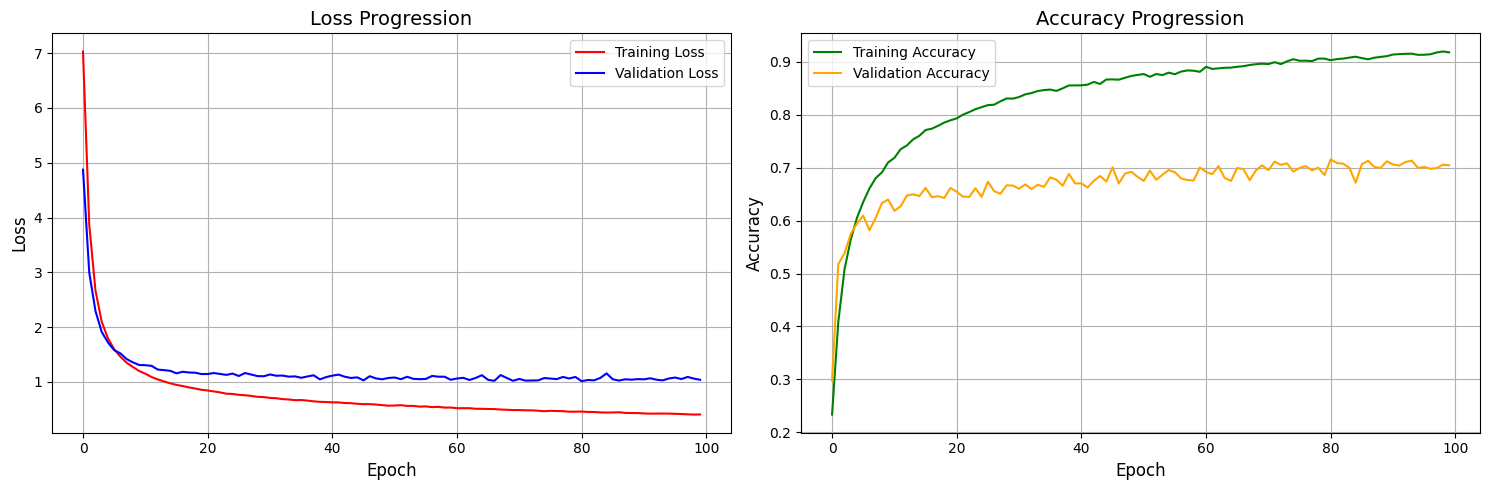

In [29]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [30]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9615 - loss: 0.2988 - weighted_accuracy: 0.9615
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7077 - loss: 1.0435 - weighted_accuracy: 0.7077


In [31]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       455
           1       0.45      0.61      0.52       492
           2       0.73      0.59      0.65       889
           3       0.86      1.00      0.92       150
           4       0.78      0.21      0.33        67
           5       0.68      0.35      0.46        43
           6       0.45      0.38      0.41        24
           7       0.95      0.95      0.95        44
           8       0.56      0.44      0.49        50
           9       0.97      0.98      0.97       169
          10       0.78      0.75      0.77        53
          11       0.73      0.53      0.61        66
          12       0.71      0.80      0.75        59
          13       0.51      0.75      0.61        57
          14       0.41      0.95      0.57        38
          15       0.74      0.66      0.70       311
          16       0.95      0.95      0.95   

### With Mel Spectrogram and MFCCs

In [32]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled), axis=-1)
print(training_features.shape)

(12565, 128, 87, 2)


In [33]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled), axis=-1)
print(validation_features.shape)

(3318, 128, 87, 2)


In [34]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 2)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,370,612 (5.23 MB)

 Trainable params: 1,370,612 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.1846 - loss: 8.0883 - weighted_accuracy: 0.1846 - val_accuracy: 0.1784 - val_loss: 4.7075 - val_weighted_accuracy: 0.1784
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2369 - loss: 4.1483 - weighted_accuracy: 0.2369 - val_accuracy: 0.3376 - val_loss: 2.9241 - val_weighted_accuracy: 0.3376
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3383 - loss: 2.7456 - weighted_accuracy: 0.3383 - val_accuracy: 0.3843 - val_loss: 2.2872 - val_weighted_accuracy: 0.3843
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3999 - loss: 2.2106 - weighted_accuracy: 0.3999 - val_accuracy: 0.3424 - val_loss: 2.0807 - val_weighted_accuracy: 0.3424
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4526 - loss: 1.9867 - weighted_accuracy: 0.4526 - val_accuracy: 0.4180 - val_loss: 1.9102 - val_weighted_accuracy: 0.4180
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 

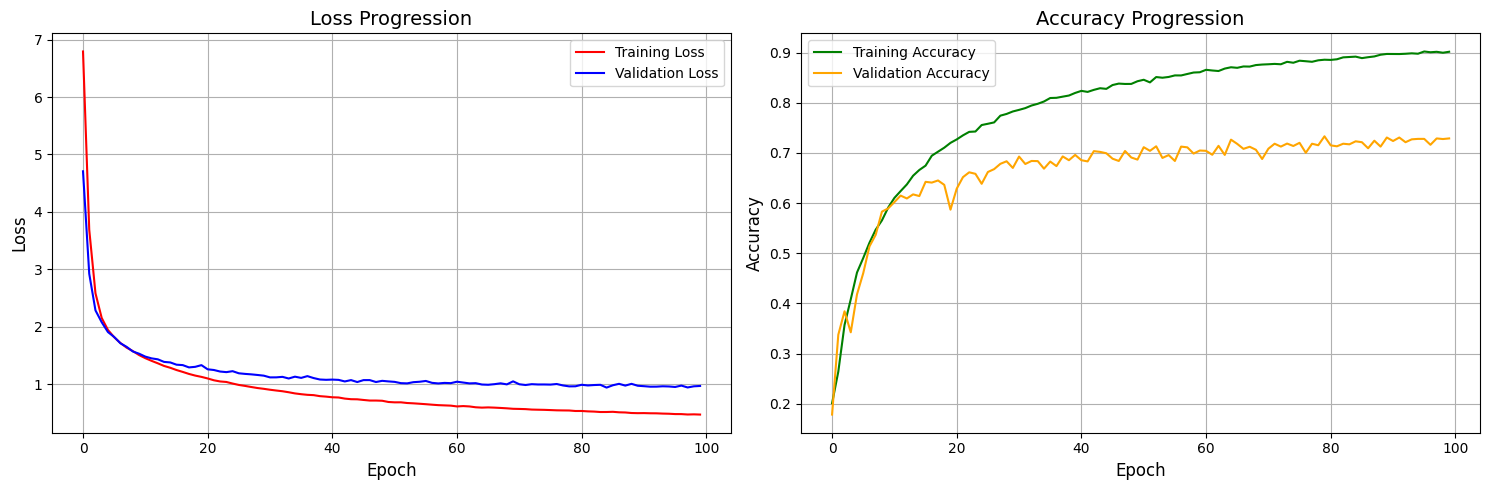

In [35]:
visualize(history, 'mfcc_melspectrogram')

In [36]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9492 - loss: 0.3422 - weighted_accuracy: 0.9492
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7365 - loss: 0.9552 - weighted_accuracy: 0.7365


In [37]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       455
           1       0.65      0.54      0.59       492
           2       0.78      0.83      0.80       889
           3       0.91      1.00      0.96       150
           4       0.60      0.04      0.08        67
           5       0.00      0.00      0.00        43
           6       0.39      0.29      0.33        24
           7       0.83      0.98      0.90        44
           8       0.51      0.52      0.51        50
           9       0.91      0.97      0.94       169
          10       0.53      0.62      0.57        53
          11       0.50      0.29      0.37        66
          12       0.65      0.78      0.71        59
          13       0.64      0.75      0.69        57
          14       0.41      0.82      0.54        38
          15       0.65      0.65      0.65       311
          16       0.95      0.96      0.95   

### With Mel Spectrogram

In [38]:
# Train features
target_size = 128

training_features = np.expand_dims(train_features['melspectrogram'], axis=-1)
print(training_features.shape)

(12565, 128, 87, 1)


In [39]:
# Validation Features
target_size = 128
validation_features = np.expand_dims(val_features['melspectrogram'], axis=-1)
print(validation_features.shape)

(3318, 128, 87, 1)


In [40]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,369,012 (5.22 MB)

 Trainable params: 1,369,012 (5.22 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.1763 - loss: 7.8926 - weighted_accuracy: 0.1763 - val_accuracy: 0.2227 - val_loss: 4.6294 - val_weighted_accuracy: 0.2227
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2379 - loss: 4.1188 - weighted_accuracy: 0.2379 - val_accuracy: 0.4078 - val_loss: 2.7669 - val_weighted_accuracy: 0.4078
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3668 - loss: 2.6480 - weighted_accuracy: 0.3668 - val_accuracy: 0.5350 - val_loss: 2.0616 - val_weighted_accuracy: 0.5350
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4791 - loss: 2.0494 - weighted_accuracy: 0.4791 - val_accuracy: 0.5720 - val_loss: 1.7475 - val_weighted_accuracy: 0.5720
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5310 - loss: 1.8138 - weighted_accuracy: 0.5310 - val_accuracy: 0.5735 - val_loss: 1.6083 - val_weighted_accuracy: 0.5735
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 

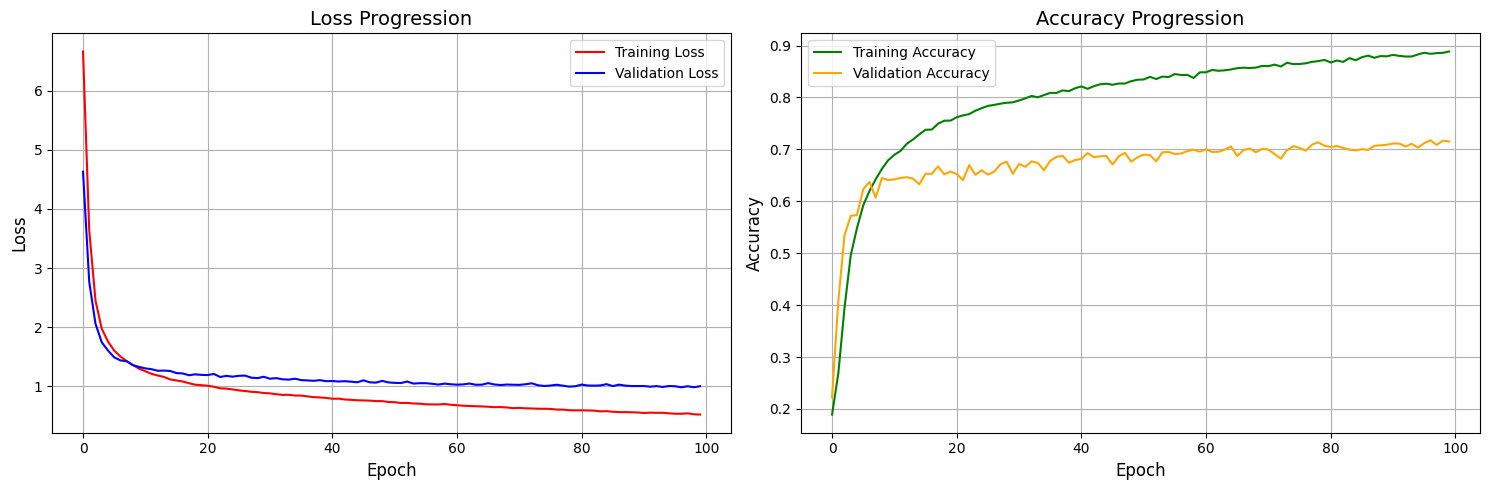

In [41]:
visualize(history, 'melspectrogram')

In [42]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9443 - loss: 0.3785 - weighted_accuracy: 0.9443
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7190 - loss: 0.9729 - weighted_accuracy: 0.7190


In [43]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       455
           1       0.55      0.52      0.54       492
           2       0.80      0.77      0.78       889
           3       0.92      1.00      0.96       150
           4       0.43      0.04      0.08        67
           5       0.17      0.02      0.04        43
           6       0.28      0.29      0.29        24
           7       0.88      1.00      0.94        44
           8       0.74      0.58      0.65        50
           9       0.96      0.96      0.96       169
          10       0.56      0.70      0.62        53
          11       0.66      0.67      0.66        66
          12       0.53      0.78      0.63        59
          13       0.69      0.70      0.70        57
          14       0.68      0.66      0.67        38
          15       0.56      0.71      0.63       311
          16       0.90      0.95      0.92   

## Review all the results

In [44]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,1.000,0.732
4,melspectrogram,0.946,0.715
1,melspectrogram_chroma,0.958,0.718
2,melspectrogram_chroma_mfcc,0.963,0.705
3,mfcc_melspectrogram,0.950,0.729


In [45]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0                all_features     0.729      0.963
4              melspectrogram     0.706      0.953
1       melspectrogram_chroma     0.714      0.949
2  melspectrogram_chroma_mfcc     0.705      0.945
3         mfcc_melspectrogram     0.715      0.960
